<h1> <center>Was 2018 an Exceptional Year for Louisville's Rainfall? </center> <h1>

2018 was a record year for Louisville with over 66 inches of rainfall. We will analyze all recorded rainfall (1872-present) for Louisville, KY (source National Weather Service - NOW Data https://w2.weather.gov/climate/xmacis.php?wfo=lmk) that is stored in CSV format with this project.

In the first few cells, we will do all of the set up needed to import the Louisville Rain CSV and perform our analysis.

In [507]:
# Import all dependecies needed.

import os
import csv
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import scipy.stats

plt.figure(figsize = (20, 10))
plt.style.use('classic');

<Figure size 1600x800 with 0 Axes>

In [508]:
# Get the current working directory via os.getcwd() so that it is relative and assign it to the directory variable.

directory = os.getcwd()
print(directory)

C:\Users\rcsall11\LouisvilleRain


In [509]:
# Since the rainfall data is stored in the \RainSourceData subdirectory we will add it to the directory variable.

directory += "\RainSourceData"
print(directory)

C:\Users\rcsall11\LouisvilleRain\RainSourceData


In [510]:
# The rainfalldata is stored in "louisville_rain_data.csv" and we will assign the directory variable plus the name of the CSV 
# to a new variable, filename.

filename = directory + "\louisville_rain_data.csv"
print(filename)

C:\Users\rcsall11\LouisvilleRain\RainSourceData\louisville_rain_data.csv


In [511]:
# Now the rainfall data, in CSV format, can be read using read_csv() from pandas and converted to a dataframe, df_louisville.

df_louisville = pd.read_csv(filename)
df_louisville.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1872,M,M,M,M,M,M,M,2.45,4.38,3.92,0.56,2.35
1,1873,2.93,5.42,3.39,3.05,5.73,2.84,3.43,3.04,2.47,3.26,2.19,6.99
2,1874,2.39,5.18,6.63,6.01,1.14,2.95,2.83,3.23,0.62,2.04,5.90,4.77
3,1875,2.42,2.09,4.54,0.98,4.07,5.79,16.46,2.19,1.05,1.92,6.14,5.67
4,1876,11.63,2.92,6.01,4.5,1,6.52,3.61,4.29,2.66,7.61,1.63,1.24


In [512]:
# Convert df_louisville to a sql table and establish a connection.

df_louisville.to_sql("louisville_rain_table", sqlite3.connect("louisville_rain.db"), if_exists = "replace")
db_lou = sqlite3.connect("louisville_rain.db")

With our CSV converted to a dataframe and then converted to a sql table. In the representation of the dataframe two cells above, there is not a column that shows the total rainfall. Below, a sql query is executed on the louisville_rain_table to get the sum of all of the month columns and create a new column "Total" displaying the results of SUM function. Afterwards, the table is converted to a pandas dataframe, and the index of the dataframe is set to the Year column to make any further lookups of data easier for our coming analysis.

In [513]:
lou_sum_query ="""
                SELECT Year, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, SUM(Jan + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Nov + Dec)  AS Total
                FROM louisville_rain_table
                GROUP BY Year
                """

df_louisville = pd.read_sql_query(lou_sum_query, db_lou)
df_louisville.set_index('Year', inplace = True)
df_louisville.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
1872,M,M,M,M,M,M,M,2.45,4.38,3.92,0.56,2.35,9.74
1873,2.93,5.42,3.39,3.05,5.73,2.84,3.43,3.04,2.47,3.26,2.19,6.99,41.48
1874,2.39,5.18,6.63,6.01,1.14,2.95,2.83,3.23,0.62,2.04,5.90,4.77,41.65
1875,2.42,2.09,4.54,0.98,4.07,5.79,16.46,2.19,1.05,1.92,6.14,5.67,51.40
1876,11.63,2.92,6.01,4.5,1,6.52,3.61,4.29,2.66,7.61,1.63,1.24,46.01


With our query exceuted and table converted back to a dataframe, there is at least one year, 1872 with "M" with amount of rainfall for that respective month. We will see if there are any other years that have months with missing rainfall data as these non-numeric values do not contribute to the total rainfall for the year. Instead of backfilling the months missing data, we will remove those rows so that years with incomplete data do not decrease the mean such as with 1872's 9.72in of total recorded rainfall. 

In [514]:
#Find all instances of "M"
df_louisville[df_louisville.eq("M").any(1)]

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
1872,M,M,M,M,M,M,M,2.45,4.38,3.92,0.56,2.35,9.74
1946,M,6.17,4.9,2.39,5.11,4.75,3.11,4.26,1.34,2.16,4.33,2.94,39.30


Since these "M"s are non-numeric and were not used to calculate total amount of rainfall for both 1872, we will check to see if they affect the datatype of each column since columns with non-numeric type would result in an error when calculating a sum or finding a maximum value. As well, we will soon need to decide what to do with these two years that have missing rainfall data.

In [515]:
# Check datatype of each column in the dataframe.
df_louisville.dtypes

Jan       object
Feb       object
Mar       object
Apr       object
May       object
Jun       object
Jul       object
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec      float64
Total    float64
dtype: object

With Jan-Jul columns being objects, we will not be able to perform any mathmathical operations or even certain pandas methods on them. We will need to convert them to a numerical type. With the pd.to_numeric() method, all of the columns can be converted to a numeric datatype. In addition, this function can also convert any errors, such as those that will occur when it tries to parse "M", to NaN(Not a Number); this will be useful when deciding what to do with the data from 1872 and 1946.

In [516]:
#Cast all object columns to numeric datatype and cast all columns to float32 as the precision with float64 is not necessary.
df_louisville = df_louisville.apply(pd.to_numeric, downcast ="float", errors="coerce")
#Check data types to confirm.
df_louisville.dtypes

Jan      float32
Feb      float32
Mar      float32
Apr      float32
May      float32
Jun      float32
Jul      float32
Aug      float32
Sep      float32
Oct      float32
Nov      float32
Dec      float32
Total    float32
dtype: object

In [517]:
#Display the head of the table to confirm "M" was converted to NaN
df_louisville.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.45,4.38,3.92,0.56,2.35,9.740000
1873,2.93,5.42,3.39,3.05,5.73,2.84,3.430000,3.04,2.47,3.26,2.19,6.99,41.480000
1874,2.39,5.18,6.63,6.01,1.14,2.95,2.830000,3.23,0.62,2.04,5.90,4.77,41.650002
1875,2.42,2.09,4.54,0.98,4.07,5.79,16.459999,2.19,1.05,1.92,6.14,5.67,51.400002
1876,11.63,2.92,6.01,4.50,1.00,6.52,3.610000,4.29,2.66,7.61,1.63,1.24,46.009998


We proceed with cleaning up the data. With both 1872 and 1946 missing monthly rainfall totals, we will omit all of 1872's and 1946's data since keeping this data would skew the mean of the yearly rainfall lower and could possibly cause the 2018 total rainfall appear more extreme than it really is. There will still be enough data to answer the question of 2018 being an extreme year in rainfall. To omit 1872 and 1946's rows from the dataframe, the pd.dropna() method will be used as it will find any instances of a NaN and drop the row or column where this occurs(in this case, rows.) In addition, we will obtain the sum of all columns as we can compare 2018's total rainfall against the mean total rainfall.

In [518]:
#Drop columns
df_louisville.dropna(axis = 'rows', how ='any', inplace = True)
#Get the mean of all of the columns
df_louisville.loc['Mean'] = df_louisville.mean(axis =0)
#Display the tail which will include the mean yearly rainfall and the total rainfall for 2018.
df_louisville.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
2015,0.870000,2.230000,7.800000,10.840000,2.380000,6.820000,8.650000,3.470000,2.450000,4.850000,5.470,6.580000,57.560001
2016,1.010000,4.810000,5.500000,3.180000,4.560000,4.250000,4.650000,5.710000,2.280000,0.650000,1.650,5.300000,42.900002
2017,4.210000,2.060000,3.680000,4.470000,4.740000,3.260000,2.790000,4.200000,5.470000,4.890000,2.060,2.730000,39.669998
2018,1.760000,10.540000,5.050000,3.400000,4.980000,6.380000,5.130000,7.230000,10.910000,2.790000,4.760,5.900000,66.040001
Mean,3.723724,3.371448,4.574482,4.129103,4.264689,3.930138,3.910344,3.359104,2.997242,2.826552,3.522,3.764207,41.546482


Now that the data has been cleaned up, we can move to our analysis to determine if Louisville's 2018 rainfall was extreme. To answer this question, several different methods will be used to determine if 2018's rainfall is truely an outlier. Firstly, let's graphically look at 2018's total rainfall against the average rainfall. This will be plotted to a column chart.

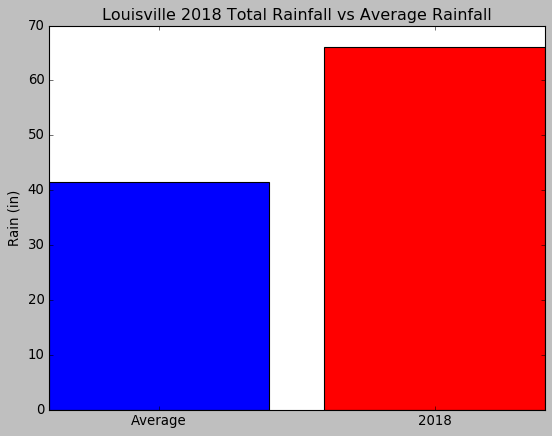

In [519]:
#Assign the 2018's total rainfall and the average yearly rainfall to variables 
#to be used in a column graph and other calculations
louisvilleTotalRainFall2018 = df_louisville.loc[2018, 'Total']
louisvilleTotalRainFallMean = df_louisville.loc['Mean', 'Total']

#Plot the average  rainfall against the 2018 rainfall
objects = ("Average", "2018")
color = ["blue", "red"]
plt.bar(objects,[louisvilleTotalRainFallMean, louisvilleTotalRainFall2018], color = color, align = "center")
plt.title("Louisville 2018 Total Rainfall vs Average Rainfall")
plt.ylabel("Rain (in)")
plt.show()

Graphically, Louisville's rainfall appears significantly greater than the average rainfall in Louisville. We can determine the difference from the mean for a concrete value by subtracting the mean from the total rainfall for 2018.

In [520]:
louisville2018RainFallDifference = (louisvilleTotalRainFall2018 - louisvilleTotalRainFallMean)
louisville2018RainFallDifference

24.493519

The total rainfall for Louisville in 2018 was 24.49 inches above average. This certainly sounds very large, but we can graphically compare 2018's against all other years by plotting them on a scatterplot to see if 2018's rainfall is extreme.

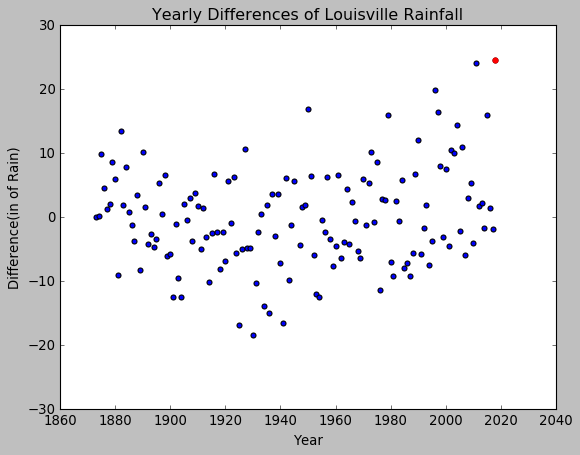

In [521]:
#Assign the 'Total' column to a variable
louisvilleTotalRainFallSeries = df_louisville['Total']
#Assign years and differnces variables to empty lists
years = []
differences = []
#Loop through a slice louisvilleTotalRainfallSeries to exclude the mean and add each year to its the years list,  
# calculate the difference from the meanm and add the difference its list.
for i, r in louisvilleTotalRainFallSeries[0:-1].items():
    years.append(i)
    differences.append(r-louisvilleTotalRainFallMean)
    
#Plot the differences    
plt.scatter(years, differences)
#Highlight the 2018 difference by plotting it to the scatterplot in red.
plt.scatter(years[-1], differences[-1], color = "red")
plt.xlabel("Year")
plt.ylabel("Difference(in of Rain)")
plt.title("Yearly Differences of Louisville Rainfall")
plt.show()

In [522]:
louisvilleTotalRainFallList = []
louisvilleTotalRainFallList = louisvilleTotalRainFallSeries.tolist()
louisvilleTotalRainFallList.pop()

41.54648208618164

In [523]:
louMeanStdDev = statistics.stdev(louisvilleTotalRainFallList)
louMeanStdDev

7.892217065062169

In [524]:
zScoreLou=louisville2018RainFallVarience/louMeanStdDev
print(zScoreLou)
#z-score

3.1035029355408086


In [525]:
p_value = 1 - scipy.special.ndtr(zScoreLou)
print(p_value * 100)

0.09562216883818309


In [526]:
q75Lou,  q25Lou = np.percentile(louisvilleTotalRainFallList, [75, 25])
iqrLouisville = q75Lou - q25Lou
iqrLouisville

10.359996795654297

In [527]:
louisvilleTotalRainFall2018 > (q75Lou + 1.5*iqrLouisville)

True

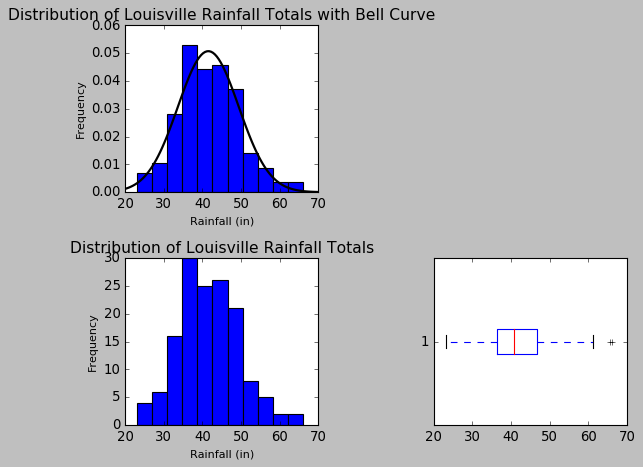

In [528]:
plt.subplot(2, 2, 1)
plt.hist(louisvilleTotalRainFallList, 'auto', density = 'True')
plt.title("Distribution of Louisville Rainfall Totals with Bell Curve", fontsize = 14)
plt.xlabel("Rainfall (in)", fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)

mu, std = norm.fit(louisvilleTotalRainFallList)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.subplot(2,2,3)
plt.hist(louisvilleTotalRainFallList, 'auto')
plt.title("Distribution of Louisville Rainfall Totals", fontsize = 14)
plt.xlabel("Rainfall (in)", fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)

plt.subplot(2,2,4)
plt.boxplot(louisvilleTotalRainFallList, vert = False)

plt.tight_layout()
plt.show()